# Modeling Notebook with Balanced Dataset

# Importing Packages

In [31]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import pickle
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, auc, average_precision_score, confusion_matrix, roc_auc_score

import re
from nltk.stem import WordNetLemmatizer
import gensim
from gensim.parsing.preprocessing import STOPWORDS


%reload_ext autoreload
%autoreload 2
import sys
sys.path.append("../py")
from utils import *
from preprocess import *


In [32]:
train = pickle.load(open("../pickle/train_bal.pickle", "rb"))
val = pickle.load(open("../pickle/val_bal.pickle", "rb"))
# test = pickle.load(open("../pickle/test_bal.pickle", "rb"))

In [33]:
train.head()

,tweet,target
0,@Ricky___m you bitch -.-,1
1,RT @iOnlyGoRaw: Took this bitch 3 months to pu...,1
2,Kim K is alright but honestly so many niggas b...,1
3,That bitch was worried about fines? Fuck you. ...,1
4,@OurCofE An end to the ordination of women and...,1


In [34]:
train.target.value_counts()

1    17514
0    17514
Name: target, dtype: int64

In [28]:
val.head()

,tweet,target
0,@kiela_g_3 Home fag. Didn't feel like puttin u...,1
1,GTA online today bitch ass niggas,1
2,Can u say hoe hoe hoe? Ewww she was nasty. I w...,1
3,@itzbreak that spear chucker? Hell no.,1
4,Oscar &amp; I used to make fun of Chaco-wearin...,1


In [35]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer as VS
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

In [12]:
# nltk.download('wordnet', download_dir='C:\\Users\\SRISHTI/nltk_data', quiet=True, halt_on_error=False, force=True)

In [36]:
stopwords = nltk.corpus.stopwords.words("english")

#extending the stopwords to include other words used in twitter such as retweet(rt) etc.
other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)
stemmer = PorterStemmer()

In [56]:
# nltk.download('wordnet', download_dir='C:\\Users\\SRISHTI\\OneDrive\\Desktop\\MachineLearning\\Hate_Speech_Detection\\Hate-Tweet-Flask\\nltk_data\\', quiet=True, halt_on_error=False, force=True)

# nltk.download('wordnet', 'C:\Users\SRISHTI\OneDrive\Desktop\MachineLearning\Hate_Speech_Detection\Hate-Tweet-Flask/nltk_data/')

True

In [37]:
def preprocess(tweet):  
    
    # removal of extra spaces
    regex_pat = re.compile(r'\s+')
    tweet_space = tweet.str.replace(regex_pat, ' ')

    # removal of @name[mention]
    regex_pat = re.compile(r'@[\w\-]+')
    tweet_name = tweet_space.str.replace(regex_pat, '')

    # removal of links[https://abc.com]
    giant_url_regex =  re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
            '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    tweets = tweet_name.str.replace(giant_url_regex, '')
    
    # removal of punctuations and numbers
    punc_remove = tweets.str.replace("[^a-zA-Z]", " ")
    # remove whitespace with a single space
    newtweet=punc_remove.str.replace(r'\s+', ' ')
    # remove leading and trailing whitespace
    newtweet=newtweet.str.replace(r'^\s+|\s+?$','')
    # replace normal numbers with numbr
    newtweet=newtweet.str.replace(r'\d+(\.\d+)?','numbr')
    # removal of capitalization
    tweet_lower = newtweet.str.lower()
    
    # tokenizing
    tokenized_tweet = tweet_lower.apply(lambda x: x.split())
    
    # removal of stopwords
    tokenized_tweet=  tokenized_tweet.apply(lambda x: [item for item in x if item not in stopwords])
    
    # stemming of the tweets
    tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) 
    
    tweets_p = []
    for i in tokenized_tweet:
        t = ' '.join(i)
        tweets_p.append(t)
    return tweets_p
    

In [38]:
train.tweet = preprocess(train.tweet)   
train.head()


,tweet,target
0,bitch,1
1,took bitch month put scarf smfh,1
2,kim k alright honestli mani nigga rather miley...,1
3,bitch worri fine fuck best friend got jump coc...,1
4,end ordin women faggot whose aim weaken split ...,1


In [39]:
val.tweet = preprocess(val.tweet)   
val.head()

,tweet,target
0,home fag feel like puttin shit today,1
1,gta onlin today bitch ass nigga,1
2,u say hoe hoe hoe ewww nasti mean daili spare ...,1
3,spear chucker hell,1
4,oscar amp use make fun chaco wear peopl togeth...,1


# Modeling

In [68]:
X_tr = train.tweet.values
X_val = val.tweet.values
y_tr = train.target.values
y_val = val.target.values
vec = TfidfVectorizer()
# X_tr= 
tfidf_tr = vec.fit_transform([str(item) for item in X_tr])
tfidf_val = vec.transform([str(item) for item in X_val])


In [82]:
tfidf_tr1=vec.fit_transform(X_tr)
tfidf_tr1.shape

(35028, 13378)

In [69]:
# X_tr1=X_tr.split('\n')
# y_tr1=y_tr.split('\n')
[str(item) for item in X_tr]

['bitch',
 'took bitch month put scarf smfh',
 'kim k alright honestli mani nigga rather miley got unfollow bitch strang',
 'bitch worri fine fuck best friend got jump cock sucker fine least worri',
 'end ordin women faggot whose aim weaken split communion',
 'free niggah',
 'still live hope one day hot rich boy fall love even though im trash',
 'nig ok big time shit talker twitter name face info',
 'best own bird could teach funniest thing say',
 'girl fuck back gt gt gt last one trash',
 'bitch phone gonna die seriou got hot pocket',
 'ayyyyy sip free slurpe see front bottom tonight happi clam',
 'pussi wet gotta dri outsid stop tell busi',
 'yeah heard fuck nut like swag fag',
 'fat hoe alway wanna beef somebodi yall need around type beef',
 'ur ex girlfriend slut fr f dat hoe',
 'ofcours someon ask els eat jackass goe browni big surpris dingbat',
 'fuckin pussi make fun peopl day radio someon call creep block',
 'bitch truli shit',
 'rich pussi bullshit rich problem idea independ f

In [85]:
pickle.dump(vec, open("../pickle/vec.pickle", "wb"))

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns

In [72]:
def get_metrics(X, y, y_pred, model):
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    rec = recall_score(y, y_pred)
    prec = precision_score(y, y_pred)
    
    
    print('Accuracy: ', acc)
    print('F1: ', f1)
    print('Recall: ', rec)
    print('Precision: ', prec)
   

def get_confusion(y, y_pred):
    cnf = confusion_matrix(y, y_pred)
    group_names = ['TN','FP','FN','TP']
    group_counts = ['{0:0.0f}'.format(value) for value in cnf.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cnf.flatten()/np.sum(cnf)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    fig, ax = plt.subplots(figsize=(4,4))
    sns.heatmap(cnf, annot=labels, fmt='', cmap='Blues', annot_kws={'size':14}, cbar=False, xticklabels=False, yticklabels=False)

In [73]:
train.target.value_counts()

1    17514
0    17514
Name: target, dtype: int64

## Multinomial Naive Bayes Model

Accuracy:  0.8811440315122453
F1:  0.8735883424408014
Recall:  0.8213735228635041
Precision:  0.9328924333787201


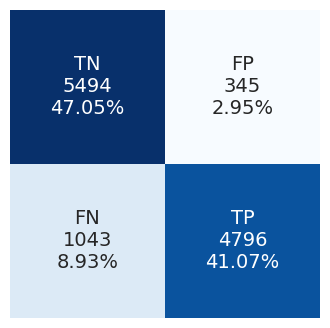

In [74]:
nb = MultinomialNB().fit(tfidf_tr, y_tr)
y_pr_nb_val = nb.predict(tfidf_val)
get_metrics(tfidf_val, y_val, y_pr_nb_val, nb)
get_confusion(y_val,y_pr_nb_val)

## Random Forest Classifier

Accuracy:  0.9871553348176058
F1:  0.9870084877879786
Recall:  0.9758520294570988
Precision:  0.998422989311372


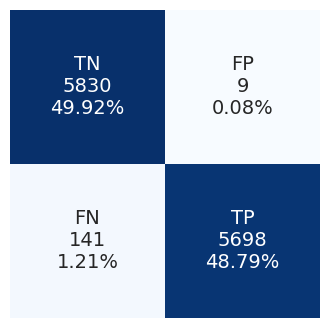

In [46]:
rf = RandomForestClassifier(n_estimators=100, random_state=42).fit(tfidf_tr, y_tr)
y_pr_rf_val = rf.predict(tfidf_val)
get_metrics(tfidf_val, y_val, y_pr_rf_val, rf)
get_confusion(y_val,y_pr_rf_val)

## Logistic Regression

Accuracy:  0.9278986127761603
F1:  0.9255394411036435
Recall:  0.8962151053262545
Precision:  0.9568476869628817


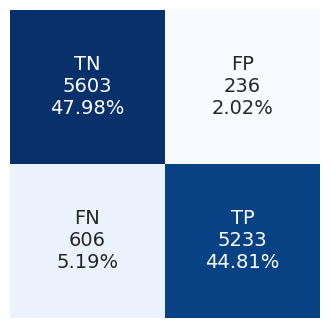

In [75]:
model = LogisticRegression(penalty='l2', C=1.0, solver='liblinear',random_state=42)
log = model.fit(tfidf_tr, y_tr)
y_pr_log_val = log.predict(tfidf_val)
get_metrics(tfidf_val, y_val, y_pr_log_val, log)
get_confusion(y_val,y_pr_log_val)

## Support Vector Machine

Accuracy:  0.9469087172461038
F1:  0.9446428571428571
Recall:  0.9059770508648741
Precision:  0.9867562022010818


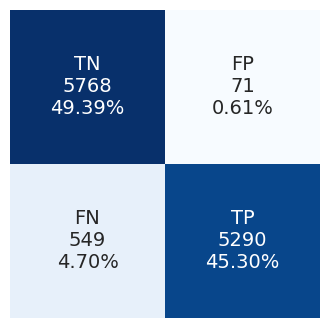

In [48]:
svc = svm.LinearSVC(random_state=42).fit(tfidf_tr, y_tr)
y_pr_svc_val = svc.predict(tfidf_val)
get_metrics(tfidf_val, y_val, y_pr_svc_val, svc)
get_confusion(y_val,y_pr_svc_val)

## AdaBoost Classifier

Accuracy:  0.8534851858194896
F1:  0.8564717725023069
Recall:  0.8742935434149683
Precision:  0.8393620519565932


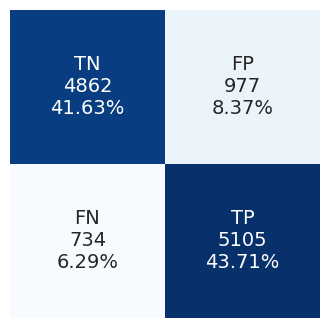

In [49]:
abc = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=200,
    random_state=42
    ).fit(tfidf_tr, y_tr)
y_pr_abc_val = abc.predict(tfidf_val)
y_pr_svc_val
get_metrics(tfidf_val, y_val, y_pr_abc_val, abc)
get_confusion(y_val,y_pr_abc_val)

## Gradient Boosting

Accuracy:  0.827967117657133
F1:  0.8336231884057972
Recall:  0.8619626648398698
Precision:  0.8070878768441309


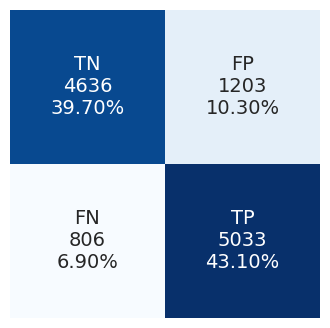

In [50]:
gbc = GradientBoostingClassifier(random_state=42).fit(tfidf_tr, y_tr)
y_pr_gbc_val = gbc.predict(tfidf_val)
get_metrics(tfidf_val, y_val, y_pr_gbc_val, gbc)
get_confusion(y_val,y_pr_gbc_val)

## Metrics Dataframe

In [51]:
data = {'Accuracy': [accuracy_score(y_val, y_pr_nb_val), 
                     accuracy_score(y_val, y_pr_rf_val), 
                     accuracy_score(y_val, y_pr_log_val), 
                     accuracy_score(y_val, y_pr_svc_val),
                     accuracy_score(y_val, y_pr_abc_val),
                     accuracy_score(y_val, y_pr_gbc_val)],
        'F1 Score': [f1_score(y_val, y_pr_nb_val), 
                     f1_score(y_val, y_pr_rf_val), 
                     f1_score(y_val, y_pr_log_val), 
                     f1_score(y_val, y_pr_svc_val),
                     f1_score(y_val, y_pr_abc_val),
                     f1_score(y_val, y_pr_gbc_val)],
        'Recall': [recall_score(y_val, y_pr_nb_val), 
                   recall_score(y_val, y_pr_rf_val), 
                   recall_score(y_val, y_pr_log_val),
                   recall_score(y_val, y_pr_svc_val),
                   recall_score(y_val, y_pr_abc_val),
                   recall_score(y_val, y_pr_gbc_val)],
        'Precision': [precision_score(y_val, y_pr_nb_val), 
                      precision_score(y_val, y_pr_rf_val), 
                      precision_score(y_val, y_pr_log_val),
                      precision_score(y_val, y_pr_svc_val),
                      precision_score(y_val, y_pr_abc_val),
                      precision_score(y_val, y_pr_gbc_val)]
        }
metrics5 = pd.DataFrame(data=data, index = ['Multinomial Naive Bayes', 
                                            'Random Forest',
                                            'Logistic Regression',
                                            'Support Vector Machine', 
                                            'AdaBoost Classifier', 
                                            'Gradient Boosting Classifier'])

In [52]:
metrics5

,Accuracy,F1 Score,Recall,Precision
Multinomial Naive Bayes,0.881144,0.873588,0.821374,0.932892
Random Forest,0.987155,0.987008,0.975852,0.998423
Logistic Regression,0.927899,0.925539,0.896215,0.956848
Support Vector Machine,0.946909,0.944643,0.905977,0.986756
AdaBoost Classifier,0.853485,0.856472,0.874294,0.839362
Gradient Boosting Classifier,0.827967,0.833623,0.861963,0.807088


In [53]:
pkl_filename = "pickle_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(nb, file)


# Hyperparameters Tuning

## Logistic Regression

In [76]:
# logreg = LogisticRegression(random_state=42)
logreg=model
params = {'C': [0.001, 0.01, 0.1, 1, 10], 
          'penalty': ['l1', 'l2', 'elasticnet'],
          'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']}
gslog = GridSearchCV(estimator = logreg,
                     param_grid = params,
                     cv = 10,
                     n_jobs = -1, 
                     verbose=3).fit(tfidf_tr, y_tr)
y_pred_gslog = gslog.predict(tfidf_val)
print("Best: %f using %s" % (gslog.best_score_, gslog.best_params_))

Fitting 10 folds for each of 75 candidates, totalling 750 fits
Best: 0.960974 using {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}


Accuracy:  0.9546155163555403
F1:  0.9528133903133902
Recall:  0.9164240452132214
Precision:  0.9922121268310773


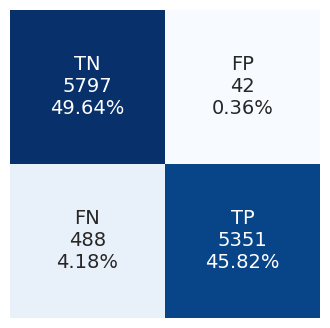

In [77]:
get_metrics(tfidf_val, y_val, y_pred_gslog, gslog)
get_confusion(y_val, y_pred_gslog)


Accuracy:  0.9493063880801507
F1:  0.9472370766488414
Recall:  0.9100873437232403
Precision:  0.9875487827541349


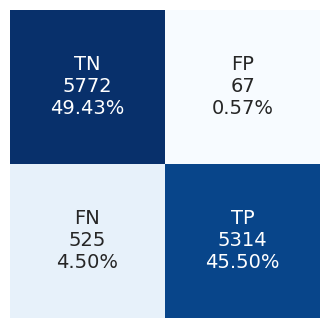

In [98]:
log_best = LogisticRegression(random_state=42, 
                              C=10, 
                              penalty='l2', 
                              solver='lbfgs').fit(tfidf_tr, y_tr)
y_pred_log_best = log_best.predict(tfidf_val)
get_metrics(tfidf_val, y_val, y_pred_log_best, log_best)
get_confusion(y_val, y_pred_log_best)

In [97]:
# y_new=y_pred_log_best
# y_pred_log_best.shape
# y_new=y_new.reshape(y_pred_log_best.shape[0],1)
# X_val


array(['home fag feel like puttin shit today',
       'gta onlin today bitch ass nigga',
       'u say hoe hoe hoe ewww nasti mean daili spare detail lol', ...,
       'said tl gotta chill pretti face challeng foolish hoe agg',
       'good morn lightskin dyke bitch steven segal ponytail',
       'bitch shut fuck goddam slut bitch whore nigga'], dtype=object)

In [79]:
pickle.dump(log_best, open("../pickle/log_best.pickle", "wb"))

In [80]:
pickle_model = pickle.load(open("../pickle/log_best.pickle", 'rb'))

## Random Forest Classifier

In [ ]:
rfc = RandomForestClassifier(random_state=42)
params = {'n_estimators': [500, 1000, 2000, 5000]}
gsrfc = GridSearchCV(estimator = rfc,
                     param_grid = params,
                     cv = 5,
                     n_jobs = -1,
                     verbose=2).fit(tfidf_tr, y_tr)
y_pred_gsrfc = gsrfc.predict(tfidf_val)
print("Best: %f using %s" % (gsrfc.best_score_, gsrfc.best_params_))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best: 0.904793 using {'n_estimators': 1000}


In [ ]:
rfc = RandomForestClassifier(random_state=42)
params = {'n_estimators': [50, 100, 200, 400, 600, 800, 1000]}
gsrfc = GridSearchCV(estimator = rfc,
                     param_grid = params,
                     cv = 5,
                     n_jobs = -1,
                     verbose=2).fit(tfidf_tr, y_tr)
y_pred_gsrfc = gsrfc.predict(tfidf_val)
print("Best: %f using %s" % (gsrfc.best_score_, gsrfc.best_params_))

In [ ]:
rfc = RandomForestClassifier(random_state=42)
params = {'n_estimators': [1000],
          'max_depth': [1500],
          'min_samples_leaf': [1, 2, 4]
         }
gsrfc = GridSearchCV(estimator = rfc,
                     param_grid = params,
                     cv = 5,
                     n_jobs = -1,
                     verbose=2).fit(tfidf_tr, y_tr)
y_pred_gsrfc = gsrfc.predict(tfidf_val)
print("Best: %f using %s" % (gsrfc.best_score_, gsrfc.best_params_))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best: 0.904793 using {'max_depth': 1500, 'min_samples_leaf': 1, 'n_estimators': 1000}


In [ ]:
rfc = RandomForestClassifier(random_state=42)
params = {'n_estimators': [1000],
          'max_depth': [1500],
          'min_samples_leaf': [1],
          'min_samples_split': [2, 5, 10]
         }
gsrfc = GridSearchCV(estimator = rfc,
                     param_grid = params,
                     cv = 5,
                     n_jobs = -1,
                     verbose=2).fit(tfidf_tr, y_tr)
y_pred_gsrfc = gsrfc.predict(tfidf_val)
print("Best: %f using %s" % (gsrfc.best_score_, gsrfc.best_params_))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best: 0.905276 using {'max_depth': 1500, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 1000}


In [ ]:
rfc_best = RandomForestClassifier(random_state=42, 
                                  max_depth=1500, 
                                  min_samples_leaf=1,
                                  min_samples_split=5, 
                                  n_estimators=1000).fit(tfidf_tr, y_tr)
y_pred_rfc_best = rfc_best.predict(tfidf_val)

Accuracy:  0.9106868553873162
F1 Score:  0.7859021567596002
ROC-AUC:  0.943451560359486
Recall:  0.7087286527514232
Precision:  0.8819362455726092
PR-AUC:  0.8864726247951304


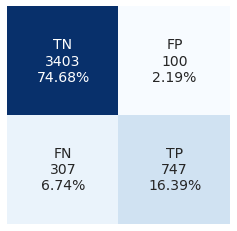

In [ ]:
get_metrics(tfidf_val, y_val, y_pred_rfc_best, rfc_best)
get_confusion(y_val,y_pred_rfc_best)

## Support Vector Machine

In [47]:
from sklearn.svm import SVC
svm = SVC()
params_grid = {'C': [0.1, 1, 10, 100]}
gssvm = GridSearchCV(SVC(),
                     params_grid,
                     refit = True,
                     verbose = 1)
gssvm.fit(tfidf_tr, y_tr)
y_pred_gssvm = gssvm.predict(tfidf_val)  
print("Best: %f using %s" % (gssvm.best_score_, gssvm.best_params_))


Fitting 5 folds for each of 4 candidates, totalling 20 fits


KeyboardInterrupt: 

In [ ]:
svm = SVC()
params_grid = {'C': [10],
               'gamma': [1, 0.1, 0.01, 0.001]}
gssvm = GridSearchCV(SVC(),
                     params_grid, 
                     refit = True, 
                     verbose = 1)
gssvm.fit(tfidf_tr, y_tr)
y_pred_gssvm = gssvm.predict(tfidf_val)  
print("Best: %f using %s" % (gssvm.best_score_, gssvm.best_params_))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best: 0.915284 using {'C': 10, 'gamma': 0.1}


In [ ]:
svm = SVC()
params_grid = {'C': [10],
               'gamma': [0.1],
               'kernel': ['rbf', 'poly', 'sigmoid']}
gssvm = GridSearchCV(SVC(),
                     params_grid, 
                     refit = True, 
                     verbose = 1)
gssvm.fit(tfidf_tr, y_tr)
y_pred_gssvm = gssvm.predict(tfidf_val)  
print("Best: %f using %s" % (gssvm.best_score_, gssvm.best_params_))

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best: 0.916557 using {'C': 10, 'gamma': 0.1, 'kernel': 'sigmoid'}


In [ ]:
get_metrics(tfidf_val, y_val, y_pred_gssvm, gssvm)

Accuracy:  0.9170506912442397
F1:  0.8014705882352942
Recall:  0.7239089184060721
Precision:  0.8976470588235295
ROC-AUC:  0.944314604830449
PR-AUC:  0.8970455202599272


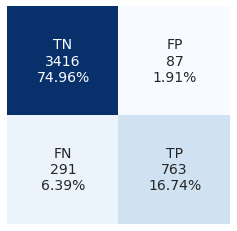

In [ ]:
get_confusion(y_val, y_pred_gssvm)

Accuracy:  0.9170506912442397
F1:  0.8014705882352942
Recall:  0.7239089184060721
Precision:  0.8976470588235295
ROC-AUC:  0.944314604830449
PR-AUC:  0.8970455202599272


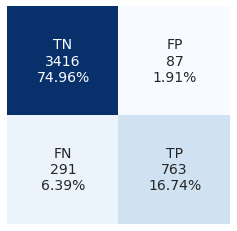

In [ ]:
svm_best = SVC(C=10, gamma=0.1, kernel='sigmoid').fit(tfidf_tr, y_tr)
y_pred_svm_best = svm_best.predict(tfidf_val)
get_metrics(tfidf_val, y_val, y_pred_svm_best, svm_best)
get_confusion(y_val, y_pred_svm_best)

In [ ]:
import pickle
with open('../pickle/best_model.pickle', 'wb') as f:
    pickle.dump(svm_best, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
data7 = {'Accuracy': [accuracy_score(y_val, y_pred_log_best),
                      accuracy_score(y_val, y_pred_gsrfc),
                      accuracy_score(y_val, y_pred_svm_best)],
        'F1 Score': [f1_score(y_val, y_pred_log_best),
                     f1_score(y_val, y_pred_gsrfc),
                     f1_score(y_val, y_pred_svm_best)],
        'Recall': [recall_score(y_val, y_pred_log_best),
                   recall_score(y_val, y_pred_gsrfc),
                   recall_score(y_val, y_pred_svm_best)],
        'Precision': [precision_score(y_val, y_pred_log_best),
                      precision_score(y_val, y_pred_gsrfc),
                      precision_score(y_val, y_pred_svm_best)]
       }
metrics7 = pd.DataFrame(data=data7, index=['Logistic Regression w/GridsearchCV',
                                           'Random Forest w/GridsearchCV',
                                           'Support Vector Machine w/GridsearchCV'])

In [ ]:
metrics7

,Accuracy,F1 Score,Recall,Precision,ROC-AUC,PR AUC
Logistic Regression w/GridsearchCV,0.924099,0.881517,0.842105,0.924798,0.965593,0.955385
Random Forest w/GridsearchCV,0.694877,0.165109,0.089983,1.000000,0.931134,0.904248
AdaBoost Classifier w/GridsearchCV,0.894307,0.820612,0.720996,0.952167,0.963641,0.936491
Support Vector Machine w/GridsearchCV,0.931879,0.893693,0.853990,0.937267,0.965325,0.954111


In [ ]:
metrics7.to_csv("../data/metrics/metrics7.csv")

In [ ]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SVC()),
])

parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__max_features':
}

}